# Natural Language Processing Summative Assignment


# Section 1 - Data Preperation

In [ ]:
### IMPORTING REQUIRED LIBRARIES
import scipy
import pickle
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from transformers import BertTokenizer, BertModel
from google.colab import drive
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,TensorDataset


In [ ]:
#LOAD TRAINING DATA!
headlines_df = pd.read_csv('https://github.com/FakeNewsChallenge/fnc-1/blob/master/train_stances.csv?raw=true')
bodies_df = pd.read_csv('https://github.com/FakeNewsChallenge/fnc-1/blob/master/train_bodies.csv?raw=true')
print("Headline Dataframe: "+str(headlines_df.columns))
print("Body Dataframe: "+str(bodies_df.columns))
#Convert stances to either UNRELATED: 0 or RELATED: 1
def stances_to_related(stances):
  stance_dict = {"unrelated":0,"agree":1,"disagree":1,"discuss":1}
  new_stances=[]
  for i in range(len(stances)):
      new_stances.append(stance_dict[stances.iloc[i]])
  return new_stances
related_df = stances_to_related(headlines_df["Stance"])

Headline Dataframe: Index(['Headline', 'Body ID', 'Stance'], dtype='object')
Body Dataframe: Index(['Body ID', 'articleBody'], dtype='object')


# Section 2 - Feature Extraction


In [ ]:
# 2. BALANCE THE DATA!! Make number of related and unrelated even. DOWNSAMPLE


def downsample(x,y):#Make the categories equal
  print("Before Downsampling")
  print("Unrelated: "+str(y.count(0))+" Related: "+str(y.count(1)))
  data = pd.concat([pd.DataFrame(x), pd.Series(y, name='label')], axis=1)
  majority_class = data['label'].value_counts().idxmax()
  minority_class = data['label'].value_counts().idxmin()
  majority_downsampled = resample(
      data[data['label'] == majority_class],
      replace=False,  # Without replacement
      n_samples=data['label'].value_counts()[minority_class],  # Match minority class size
      random_state=42
  )

  balanced_data = pd.concat([majority_downsampled, data[data['label'] == minority_class]])

  # Split the balanced data into X and y
  X_balanced = balanced_data.drop('label', axis=1)
  y_balanced = balanced_data['label']

  #print("After Downsampling")
  #print(str(y_balanced.value_counts()))
  return X_balanced,y_balanced

### Term Frequency-Inverse Document Frequency (TF-IDF)

In [ ]:
#IMPLEMENT TF-IDF HERE!
#Mention handling stop words and parameters
#Remove numbers etc

def join_texts(headlines_df):
  new_df=[]
  for index,row in headlines_df.iterrows():
    body = bodies_df[bodies_df["Body ID"]==row["Body ID"]]["articleBody"]
    joined = str(str(row["Headline"])+str(body))
    new_df.append(joined)
  return new_df

tfidf_df = join_texts(headlines_df)

#Take words only
tfidf_vectorizer = TfidfVectorizer(decode_error='ignore', lowercase=True, min_df=3)#,max_features=500)

#Balance the data here for Unrelated/Related
tfidf_dfEQ,related_dfEQ = downsample(tfidf_df, related_df)
for column in tfidf_dfEQ.columns:
  new=tfidf_dfEQ[column].tolist()
new2 = related_dfEQ.tolist()


X_train, X_test, y_train, y_test = train_test_split(new, new2, test_size=0.2, random_state=42)
X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

#MAKE D1 Fit the Transform
#Then make D2 fit that, this is a comparison of D1 against D2


Before Downsampling
Unrelated: 36545 Related: 13427


### A Transformer of your choice (DistilBERT)

In [ ]:
#Transformer uses simple FEEDFORWARD LAYERS
#Transform the input vector into three different vectors (Query,key,value)
#Use trainable weight matrices to produce three different transformations
#Helps reduce the input dimensionality
#MAIN IDEA OF BERT: Words can have different meanings in different contexts
#BERT is a training strategy
#BERT uses Masked Language Modelling (MLM) conditioned on the fullcontext of the sentence using words both on the left and on the right.

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings


model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')




In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

BATCH_SIZE=128

def tokenize_batch(inputs,batch):
  tokenized=[]
  for i in range(len(inputs)):
    headline = inputs["Headline"][i+batch]
    body = str(bodies_df.loc[bodies_df['Body ID'] == inputs["Body ID"][i+batch]]["articleBody"])
    new = tokenizer.encode(headline,body, add_special_tokens=True,padding="max_length", truncation=True,max_length=512)
    tokenized.append(new)
  return pd.Series(tokenized)

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# Placeholder for storing features from all batches
all_features = []

for batch in range(0, len(headlines_df["Headline"]), BATCH_SIZE):
  tokenized = tokenize_batch(headlines_df[batch:batch + BATCH_SIZE],batch)
  max_len = 0
  for i in tokenized.values:
      if len(i) > max_len:
          max_len = len(i)

  padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
  np.array(padded).shape

  attention_mask = np.where(padded != 0, 1, 0)

  ### 2.TRAIN BERT MODEL
  print(batch)
  input_ids = torch.tensor(padded)
  input_ids = input_ids.to(device)
  attention_mask = torch.tensor(attention_mask)
  attention_mask = attention_mask.to(device)
  print(input_ids.shape)
  print(attention_mask.shape)

  with torch.no_grad():
      last_hidden_states = model(input_ids, attention_mask=attention_mask)

  # Append the features from the current batch to the list
  batch_features = last_hidden_states[0][:, 0, :].cpu().numpy()
  all_features.append(batch_features)
  pickle.dump(all_features, open('/content/gdrive/MyDrive/NLP/temp_BERT.pkl', 'wb'))
  print("Saved Step")

# Concatenate features from all batches
BERT = np.concatenate(all_features, axis=0)
pickle.dump(BERT, open('/content/gdrive/MyDrive/NLP/BERT.pkl', 'wb'))
print("Saved All")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
0
torch.Size([128, 512])
torch.Size([128, 512])
Saved Step
128
torch.Size([128, 512])
torch.Size([128, 512])
Saved Step
256
torch.Size([128, 512])
torch.Size([128, 512])
Saved Step
384
torch.Size([128, 512])
torch.Size([128, 512])
Saved Step
512
torch.Size([128, 512])
torch.Size([128, 512])
Saved Step
640
torch.Size([128, 512])
torch.Size([128, 512])
Saved Step
768
torch.Size([128, 512])
torch.Size([128, 512])
Saved Step
896
torch.Size([128, 512])
torch.Size([128, 512])
Saved Step
1024
torch.Size([128, 512])
torch.Size([128, 512])
Saved Step
1152
torch.Size([128, 512])
torch.Size([128, 512])
Saved Step
1280
torch.Size([128, 512])
torch.Size([128, 512])
Saved Step
1408
torch.Size([128, 512])
torch.Size([128, 512])
Saved Step
1536
torch.Size([128, 512])
torch.Size([128, 512])
Saved Step
1664
torch.Size([128, 512])
torch.Size([128, 512])
Saved Step
1792
torch.

'\ndrive.mount(\'/content/gdrive\')\n\nbodies_BERT = convert_to_bert(bodies_df["articleBody"],64)\npickle.dump(bodies_BERT, open(\'/content/gdrive/MyDrive/NLP/bodies_BERT.pkl\', \'wb\'))\n\n\nheadlines_BERT = convert_to_bert(headlines_df["Headline"],64)\npickle.dump(headlines_BERT, open(\'/content/gdrive/MyDrive/NLP/headlines_BERT.pkl\', \'wb\'))\n'

In [ ]:
#bodies_BERT2 = pickle.load(open('/content/gdrive/MyDrive/NLP/bodies_BERT.pkl', 'rb'))
print(BERT.shape)
print(headlines_df.shape)

(49972, 768)
(49972, 3)


# Section 3 - Classification



#### Utility

In [ ]:
### IMPORTING REQUIRED LIBRARIES
import scipy
import pickle
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from transformers import BertTokenizer, BertModel
from google.colab import drive
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,TensorDataset


In [ ]:
#DEFINING A FUNCTION TO OUTPUT THE STATS FOR ANY MODEL

def print_metrics(y_test,y_pred,binary=True):

  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred,average="micro")
  recall = recall_score(y_test, y_pred,average="micro")
  f1 = f1_score(y_test, y_pred,average="micro")
  conf_matrix = confusion_matrix(y_test, y_pred)

  print(f"Accuracy: {accuracy}")
  print(f"Precision: {precision}")
  print(f"Recall: {recall}")
  print(f"F1 Score: {f1}")
  print("Confusion Matrix:")
  print(conf_matrix)
  conf_matrix = confusion_matrix(y_test, y_pred)

  # Labeling the confusion matrix
  if binary==True:
    conf_matrix_df = pd.DataFrame(conf_matrix, index=['Unrelated', 'Related'], columns=['Unrelated', 'Related'])
  elif binary=="SPECIAL":
    conf_matrix_df = pd.DataFrame(conf_matrix, index=['Disagree', 'Discuss','Agree','Unrelated'], columns=['Disagree', 'Discuss','Agree','Unrelated'])
  else:
    conf_matrix_df = pd.DataFrame(conf_matrix, index=['Disagree', 'Discuss','Agree'], columns=['Disagree', 'Discuss','Agree'])

  # Create a heatmap
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues", cbar=False)
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()


In [ ]:
def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []
    model.eval()
    with torch.no_grad():
        for text, labels in test_loader:
            labels = labels.to(device)
            text = text.to(device)
            output = model(text)
            output = (output > threshold).int()
            #ONLY FOR FINAL CLASSIFIER
            output=torch.argmax(output,dim=1)
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    print_metrics(y_true,y_pred)

#### Prepare Training Data

In [ ]:
# 1. LOAD THE SAVED DATA
drive.mount('/content/gdrive')
BERT = pickle.load(open('/content/gdrive/MyDrive/NLP/BERT.pkl', 'rb'))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:

X_balanced, y_balanced = downsample(BERT,related_df)

#Split data into test and train for logistic regression model
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

Before Downsampling
Unrelated: 36545 Related: 13427


### Standard Machine Learning Method - LOGISTIC REGRESSION

#### TF-IDF

TF-IDF:
Accuracy: 0.7529324148203315
Precision: 0.760324199150907
Recall: 0.7361733931240658
F1 Score: 0.7480539206379343
Confusion Matrix:
[[2074  621]
 [ 706 1970]]


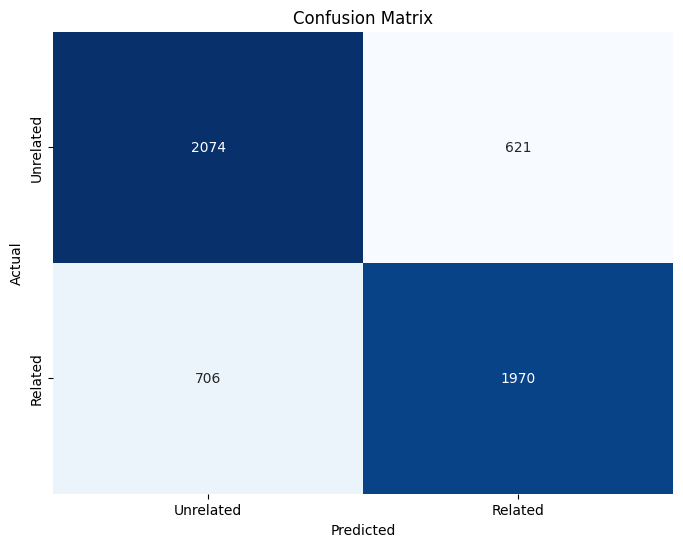

In [ ]:
#INPUT: Headline & Body of Text
#print(X_train)


TFIDF_basic_model = LogisticRegression()
TFIDF_basic_model.fit(X_train, y_train)

# Predict the target column on the test set
y_pred = TFIDF_basic_model.predict(X_test)

print("TF-IDF:")
print_metrics(y_test,y_pred)

#### BERT


BERT LOGISTIC REGRESSION MODEL:

Accuracy: 0.8162353379258983
Precision: 0.8279611650485437
Recall: 0.796711509715994
F1 Score: 0.8120358027042467
Confusion Matrix:
[[2252  443]
 [ 544 2132]]


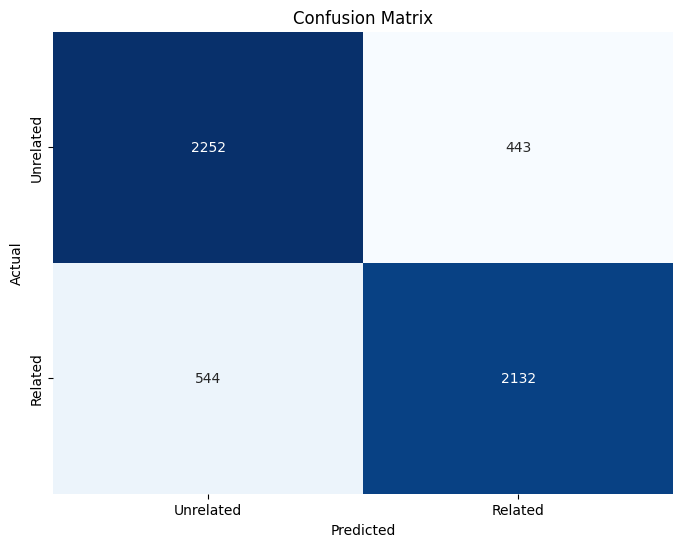

In [ ]:
#INPUT: Headline & Body of Text
TFIDF_basic_model = LogisticRegression(max_iter=2000)#NEED THIS TO CONVERGE
TFIDF_basic_model.fit(X_train, y_train)

# Predict the target column on the test set
y_pred = TFIDF_basic_model.predict(X_test)

print("\nBERT LOGISTIC REGRESSION MODEL:\n")
print_metrics(y_test,y_pred)



### Deep Learning Model - LSTM

#### TF-IDF

In [ ]:
class dataset(Dataset):
  def __init__(self,x,y):
    self.x = x#.astype(np.float32)
    self.y = y#.astype(np.float32)
    self.length = len(self.x)#.shape[0]

  def __getitem__(self,idx):
    x_tensor = torch.tensor(self.x[idx],dtype=torch.float64)
    y_tensor = torch.tensor(self.y[idx],dtype=torch.long)

    return x_tensor,y_tensor
  def __len__(self):
    return self.length


print(type(X_train))
print(X_train.shape)
print(type(y_train))
#print(len(X_train.toarray().tolist()))

X_train2 = X_train.toarray().tolist()
X_test2 = X_test.toarray().tolist()

trainset = dataset(X_train2,y_train)
valset = dataset(X_test2,y_test)
#DataLoader
train_loader = DataLoader(trainset,batch_size=64,shuffle=False,drop_last=True)
val_loader = DataLoader(valset,batch_size=64,shuffle=False,drop_last=True)




<class 'scipy.sparse._csr.csr_matrix'>
(21483, 5923)
<class 'list'>


In [ ]:
model = TEXT_LSTM()
print("Layers:")
for layer in model.children():
    print("\t{}".format(layer))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model = model.to(device)

train(model, optimizer, num_epochs=200, file_path='/content/gdrive/MyDrive/NLP2')

Layers:
	LSTM(768, 32, batch_first=True, bidirectional=True)
	Dropout(p=0.5, inplace=False)
	Linear(in_features=64, out_features=64, bias=True)
Epoch[1/200], Step [167/67000], Train loss:0.6943, Valid loss:0.6930
Model saved to ==> /content/gdrive/MyDrive/NLP2/model.pt
Metrics saved to ==> /content/gdrive/MyDrive/NLP2/metrics.pt
Epoch[1/200], Step [334/67000], Train loss:0.6938, Valid loss:0.6929
Model saved to ==> /content/gdrive/MyDrive/NLP2/model.pt
Metrics saved to ==> /content/gdrive/MyDrive/NLP2/metrics.pt
Epoch[2/200], Step [501/67000], Train loss:0.6929, Valid loss:0.6927
Model saved to ==> /content/gdrive/MyDrive/NLP2/model.pt
Metrics saved to ==> /content/gdrive/MyDrive/NLP2/metrics.pt
Epoch[2/200], Step [668/67000], Train loss:0.6930, Valid loss:0.6928
Epoch[3/200], Step [835/67000], Train loss:0.6924, Valid loss:0.6926
Model saved to ==> /content/gdrive/MyDrive/NLP2/model.pt
Metrics saved to ==> /content/gdrive/MyDrive/NLP2/metrics.pt
Epoch[3/200], Step [1002/67000], Train 

Metrics loaded from <== /content/gdrive/MyDrive/NLP2/metrics.pt


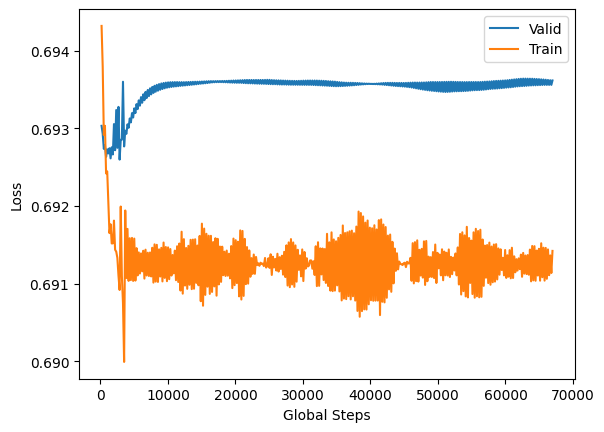

In [ ]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics('/content/gdrive/MyDrive/NLP2'+'/metrics.pt')
plt.plot(global_steps_list,valid_loss_list,label='Valid')
plt.plot(global_steps_list,train_loss_list,label='Train')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:

best_model = TEXT_LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr = 0.001)
load_checkpoint('/content/gdrive/MyDrive/NLP2'+'/model.pt',best_model,optimizer)
evaluate(best_model, val_loader)
#LOST RESULTS AND WOULD NOT RUN AGAIN!

NameError: name 'evaluate' is not defined

#### BERT

In [ ]:
#WORK ON THIS NEXT!
class dataset(Dataset):
  def __init__(self,x,y):
    self.x = x#.astype(np.float32)
    self.y = y#.astype(np.float32)
    self.length = self.x.shape[0]

  def __getitem__(self,idx):
    x_tensor = torch.tensor(self.x.iloc[idx],dtype=torch.float64)
    y_tensor = torch.tensor(self.y.iloc[idx],dtype=torch.long)
    return x_tensor,y_tensor
  def __len__(self):
    return self.length

trainset = dataset(X_train,y_train)
valset = dataset(X_test,y_test)
#DataLoader
train_loader = DataLoader(trainset,batch_size=64,shuffle=False,drop_last=True)
val_loader = DataLoader(valset,batch_size=64,shuffle=False,drop_last=True)


In [ ]:
def save_checkpoint(save_path,model,optimizer,valid_loss):
    if save_path == None:
        return
    state_dict ={'model_state_dict': model.state_dict(),
                 'optimizer_state_dict': optimizer.state_dict(),
                 'valid_loss': valid_loss}
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path,model,optimizer):
    if load_path == None:
        return
    state_dict = torch.load(load_path,map_location=torch.device("cpu"))
    print(f'Model loaded from <== {load_path}')

    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])

    return state_dict['valid_loss']

def save_metrics(save_path,train_loss_list, valid_loss_list,global_steps_list):
    if save_path==None:
        return
    state_dict= {'train_loss_list': train_loss_list,
                 'valid_loss_list': valid_loss_list,
                 'global_steps_list': global_steps_list}
    torch.save(state_dict, save_path)
    print(f'Metrics saved to ==> {save_path}')

def load_metrics(load_path):
    if load_path == None:
        return
    state_dict = torch.load(load_path)
    print(f'Metrics loaded from <== {load_path}')
    return state_dict['train_loss_list'],state_dict['valid_loss_list'],state_dict['global_steps_list']

In [ ]:
from torch import nn
from torch.nn import functional as F

class TEXT_LSTM(nn.Module):
    def __init__(self, dimension=32):
        super(TEXT_LSTM, self).__init__()
        self.rnn = nn.LSTM(
            input_size=768,
            hidden_size=dimension,
            num_layers=1,
            bidirectional=True,
            batch_first=True)
        self.drop = nn.Dropout(p=0.5)
        self.fc = nn.Linear(2*dimension, 64)
        self.double()

    def forward(self, X_batch):
        output, hidden = self.rnn(X_batch)
        #Output shape is (64,64)
        text_fea = self.drop(output[:,-1])
        #Dropped shape is (64)
        text_fea = self.fc(text_fea)
        text_out = torch.sigmoid(text_fea)
        return text_out

# Print out the layers
model = TEXT_LSTM()
print("Layers:")
for layer in model.children():
    print("\t{}".format(layer))

Layers:
	LSTM(768, 32, batch_first=True, bidirectional=True)
	Dropout(p=0.5, inplace=False)
	Linear(in_features=64, out_features=64, bias=True)


In [ ]:
def train(model,
          optimizer,
          criterion = loss_fn,
          train_loader = train_loader,
          valid_loader = val_loader,
          num_epochs = 50,
          eval_every = len(train_loader) // 2,
          file_path = "output",
          best_valid_loss = float("Inf")):

    # Initial running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list=[]
    valid_loss_list = []
    global_steps_list = []
    # Training Loop
    model.train()
    for epoch in range(num_epochs):
        losses = []
        for text, labels in train_loader:
            # Move everything to the right device
            text   = text.to(device)
            labels = labels.to(device)
            # Forward pass
            output = model(text)
            #labels = labels.view(-1, 1)
            """
            print("Label Shape: "+str(labels.shape))
            print("Output Shape: "+str(output.shape))
            """
            # Calculate loss
            loss = criterion(output.to(torch.float32), labels.to(torch.float32))
            losses.append(loss.item())

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update running values
            running_loss += loss.item()
            global_step  += 1
            # Evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():
                    # Validation loop
                    for text, labels in valid_loader:
                        labels = labels.to(device)
                        text = text.to(device)
                        output = model(text)
                        loss = criterion(output.to(torch.float32), labels.to(torch.float32))
                        valid_running_loss += loss.item()
                # Evaluation
                average_train_loss = running_loss/eval_every
                average_valid_loss = valid_running_loss/len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)
                # Resetting running values
                running_loss = 0.0
                valid_running_loss = 0.0
                model.train()
                print('Epoch[{}/{}], Step [{}/{}], Train loss:{:.4f}, Valid loss:{:.4f}'.format(
                epoch+1, num_epochs, global_step, num_epochs*len(train_loader),average_train_loss,
                    average_valid_loss))

                # Checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path+'/model.pt',model, optimizer, best_valid_loss)
                    save_metrics(file_path+'/metrics.pt',train_loss_list,valid_loss_list,global_steps_list)

    save_metrics(file_path+'/metrics.pt', train_loss_list,valid_loss_list,global_steps_list)
    print('Training is Done!')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model = model.to(device)
train(model, optimizer, num_epochs=200, file_path='/content/gdrive/MyDrive/NLP')

AttributeError: 'csr_matrix' object has no attribute 'iloc'

Metrics loaded from <== /content/gdrive/MyDrive/NLP/metrics.pt


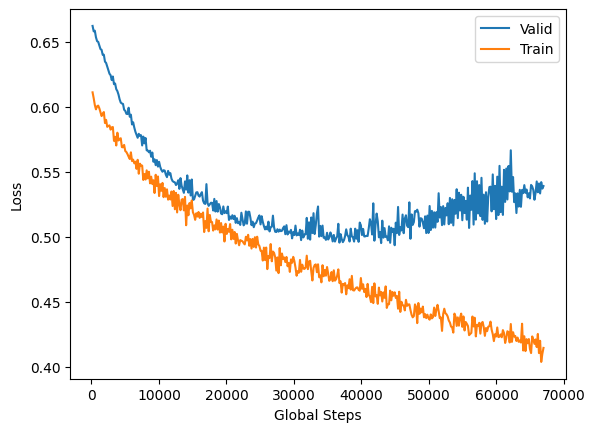

In [ ]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics('/content/gdrive/MyDrive/NLP'+'/metrics.pt')
plt.plot(global_steps_list,valid_loss_list,label='Valid')
plt.plot(global_steps_list,train_loss_list,label='Train')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

Classification Report:
              precision    recall  f1-score   support

           1     0.7625    0.7282    0.7449      2649
           0     0.7412    0.7743    0.7574      2663

    accuracy                         0.7513      5312
   macro avg     0.7518    0.7513    0.7512      5312
weighted avg     0.7518    0.7513    0.7512      5312



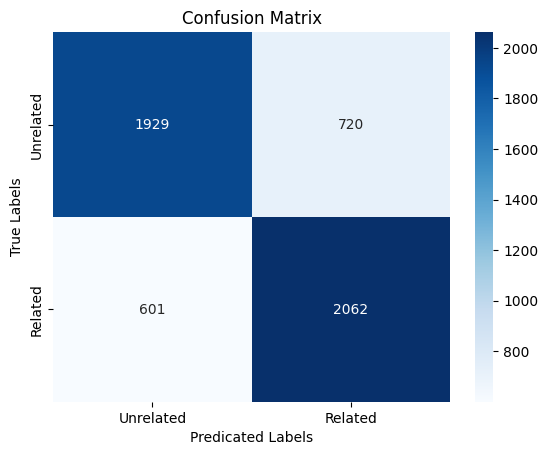

In [ ]:
# Predict the target column on the test set
evaluate(model, val_loader)

Model loaded from <== /content/gdrive/MyDrive/NLP/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.7631    0.7527    0.7579      2649
           0     0.7573    0.7676    0.7624      2663

    accuracy                         0.7602      5312
   macro avg     0.7602    0.7601    0.7601      5312
weighted avg     0.7602    0.7602    0.7602      5312

Accuracy: 0.7601656626506024
Precision: 0.7631075392269422
Recall: 0.7527368818422046
F1 Score: 0.757886735081718
Confusion Matrix:
[[2044  619]
 [ 655 1994]]


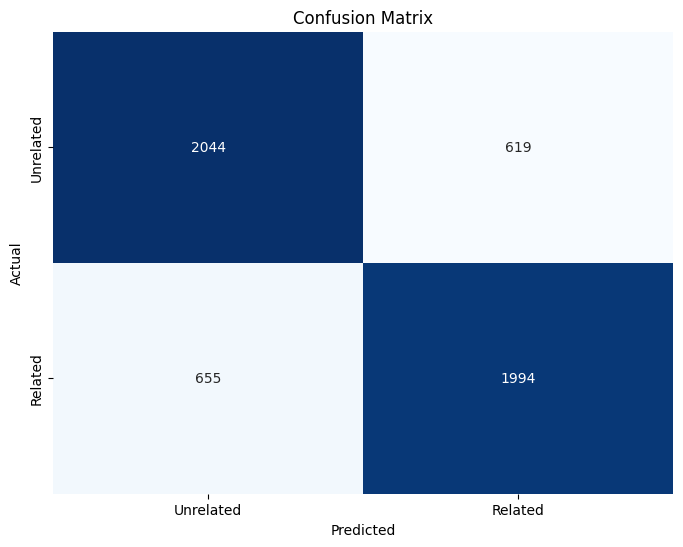

In [ ]:
best_model = TEXT_LSTM()#.to(device)
optimizer = optim.Adam(best_model.parameters(), lr = 0.001)
load_checkpoint('/content/gdrive/MyDrive/NLP'+'/model.pt',best_model,optimizer)
evaluate(best_model, val_loader)

### Agree/Disagree/Discuss Deep Learning Model - LSTM

In [ ]:
from torch import nn
from torch.nn import functional as F
class TEXT_LSTM_MULTI(nn.Module):
    def __init__(self, dimension=32):
        super(TEXT_LSTM_MULTI, self).__init__()
        self.fc = nn.Linear(768, 3)
        self.dropout = nn.Dropout(p=0.5)
        self.double()

    def forward(self, X_batch):
        text_fea = self.dropout(X_batch)
        text_fea = self.fc(text_fea)
        text_out = F.softmax(text_fea, dim=1)  # Use softmax for multi-class classification
        return text_out

In [ ]:
#USE THE SPLIT DATA TO DO THIS TASK ONLY!!!
#ONLY PASS THIS RELATED DATA
#USE THE CLASSIFIER TO FIND IF IT IS Agree/Disagree/Discuss
def stances_encode(stances):
  stance_dict = {"unrelated":0,"agree":2,"disagree":0,"discuss":1}
  new_stances=[]
  for i in range(len(stances)):
      new_stances.append(int(stance_dict[stances.iloc[i]]))
  return pd.DataFrame(new_stances)


#1. Prep dataset
# Combine X and y into a single DataFrame
data = pd.concat([pd.DataFrame(BERT),pd.DataFrame(headlines_df["Stance"])], axis=1)
#Remove Unrelated
data = data[data["Stance"]!="unrelated"]
#Balance the classes
print(data["Stance"].value_counts())
# Determine the minimum number of samples in a class
min_samples = data['Stance'].value_counts().min()
print(min_samples)
data = data.groupby('Stance').apply(lambda x: x.sample(min_samples, replace=True, random_state=42))
print(data["Stance"].value_counts())

# Split the balanced data into X and y
X_balanced = data.drop('Stance', axis=1)
y_balanced = data['Stance']
y_balanced = stances_encode(y_balanced)
y_balanced = y_balanced.astype(int)
#Split data into test and train for logistic regression model
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

#2 Create model
print("LOOK HERE")
trainset = dataset(X_train,y_train)
valset = dataset(X_test,y_test)
#DataLoader
train_loader = DataLoader(trainset,batch_size=64,shuffle=False,drop_last=True)
val_loader = DataLoader(valset,batch_size=64,shuffle=False,drop_last=True)

# Print out the layers
model = TEXT_LSTM_MULTI()
print("Layers:")
for layer in model.children():
    print("\t{}".format(layer))

#3. Run
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model = model.to(device)

train_multi(model, optimizer, num_epochs=400, file_path='/content/gdrive/MyDrive/NLP2',criterion=loss_fn)




discuss     8909
agree       3678
disagree     840
Name: Stance, dtype: int64
840
agree       840
disagree    840
discuss     840
Name: Stance, dtype: int64
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2016 entries, ('agree', 49475) to ('disagree', 45272)
Columns: 768 entries, 0 to 767
dtypes: float32(768)
memory usage: 6.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2016 entries, 51 to 860
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       2016 non-null   int64
dtypes: int64(1)
memory usage: 31.5 KB
None
0    0
Name: 1127, dtype: int64
LOOK HERE
Layers:
	Linear(in_features=768, out_features=3, bias=True)
	Dropout(p=0.5, inplace=False)


KeyboardInterrupt: 

Precision: 0.4642857142857143
Recall: 0.4642857142857143
F1 Score: 0.4642857142857143
Confusion Matrix:
[[  0  96  57]
 [  0 139   7]
 [  0  80  69]]


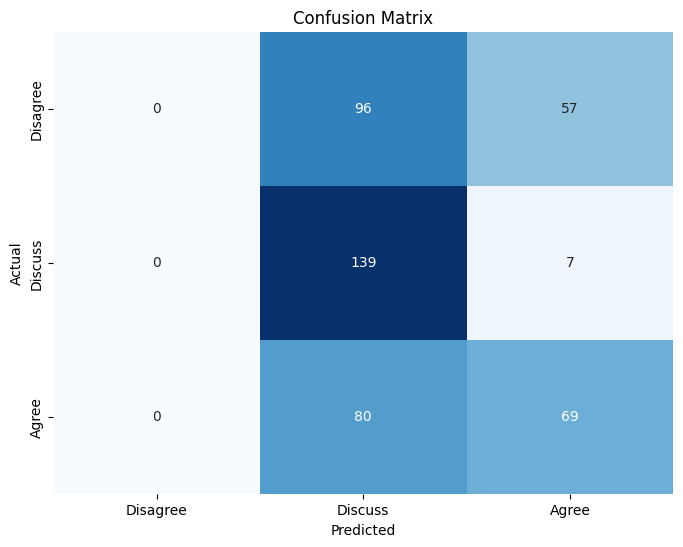

In [ ]:
#SHOW GRAPH HERE TOO!
evaluate(model, val_loader)

Model loaded from <== /content/gdrive/MyDrive/NLP2/model.pt
Accuracy: 0.49330357142857145
Precision: 0.49330357142857145
Recall: 0.49330357142857145
F1 Score: 0.49330357142857145
Confusion Matrix:
[[  0  80  73]
 [  0 135  11]
 [  0  63  86]]


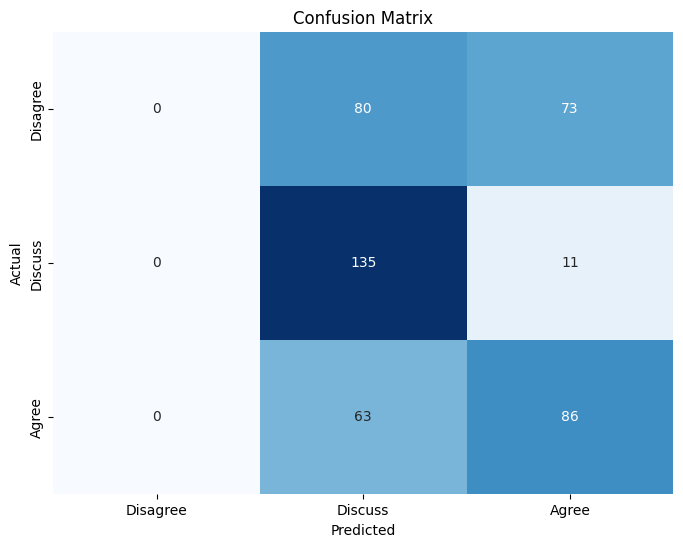

In [ ]:
best_model = TEXT_LSTM_MULTI().to(device)
optimizer = optim.Adam(best_model.parameters(), lr = 0.001)
load_checkpoint('/content/gdrive/MyDrive/NLP2'+'/model.pt',best_model,optimizer)
evaluate(best_model, val_loader)

# Section 4 - Combined Model

Model loaded from <== /content/gdrive/MyDrive/NLP/model.pt
Model loaded from <== /content/gdrive/MyDrive/NLP2/model.pt
Accuracy: 0.7439903846153846
Precision: 0.7439903846153846
Recall: 0.7439903846153846
F1 Score: 0.7439903846153847
Confusion Matrix:
[[5305 2017]
 [ 539 2123]]


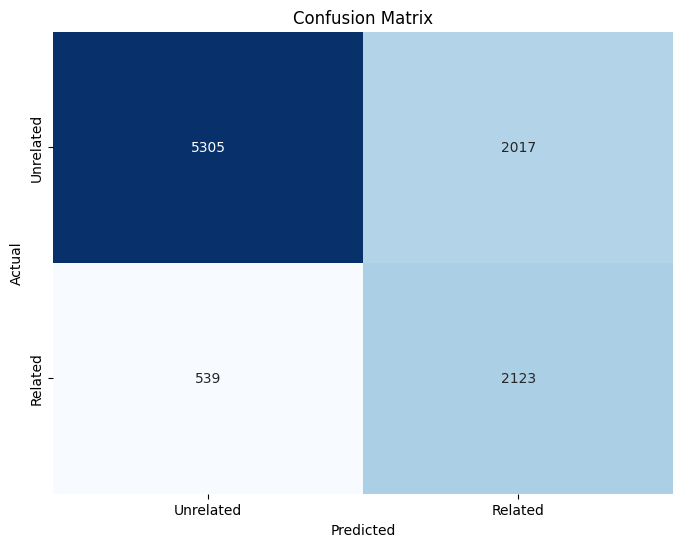

9995
9984
<class 'pandas.core.frame.DataFrame'>
tensor([-5.3166e-02, -1.0533e-01, -3.5953e-02, -1.3531e-01, -1.1783e-01,
        -1.2044e-01,  2.8581e-01,  2.1409e-01, -1.2024e-01, -1.2451e-01,
        -2.3112e-01, -1.7057e-01, -1.6735e-01,  3.8671e-01,  8.2723e-02,
         2.4020e-01, -2.1748e-01,  3.2083e-01,  8.1778e-02,  5.5353e-02,
         1.6721e-01, -5.6774e-01,  3.9804e-01, -1.7127e-01,  3.9894e-02,
        -6.2738e-02,  4.9630e-02,  8.4542e-03, -2.8544e-01,  1.3603e-01,
        -1.5390e-01,  1.0596e-01, -7.2532e-02, -9.9960e-02,  1.1372e-01,
        -6.5449e-02,  1.0510e-01,  1.4327e-01,  9.1690e-02,  9.7980e-02,
         4.9462e-02, -4.5607e-02, -2.7585e-02,  1.4617e-01,  3.1608e-02,
        -1.5628e-01, -2.2315e+00,  7.0742e-02, -2.5031e-01, -2.2275e-01,
         2.1275e-01, -5.6811e-03,  2.0068e-01,  1.8623e-01,  3.6988e-01,
         2.3830e-01, -1.9335e-01,  1.4237e-01,  1.4192e-01,  1.0866e-01,
         2.4344e-01,  1.2911e-02,  1.8566e-01, -6.9848e-02, -3.2122e-02,
   

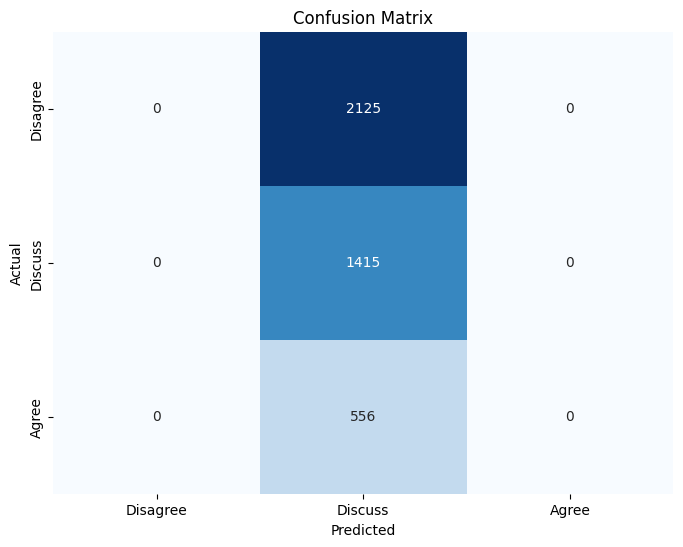

Accuracy: 0.676056338028169
Precision: 0.676056338028169
Recall: 0.676056338028169
F1 Score: 0.676056338028169
Confusion Matrix:
[[   0 2125    0   49]
 [   0 1415    0  346]
 [   0  556    0  144]
 [   0    0    0 5305]]


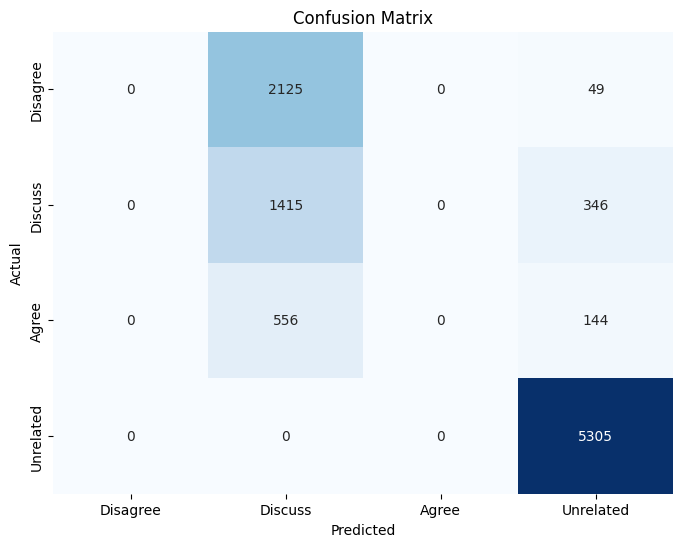

In [ ]:
def predict(model, test_loader, version='title', threshold=0.5,binary=True):
    y_pred = []
    y_true = []
    texts =[]
    model.eval()
    with torch.no_grad():
        for text, labels in test_loader:
            labels = labels.to(device)
            text = text.to(device)
            output = model(text)
            output = (output > threshold).int()
            #ONLY FOR FINAL CLASSIFIER
            if binary==False:
              output=torch.argmax(output,dim=1)
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
            texts.extend(text)

    return y_pred,y_true,texts

def global_encode(stances):
  stance_dict = {"unrelated":3,"agree":2,"disagree":0,"discuss":1}
  new_stances=[]
  for i in range(len(stances)):
      new_stances.append(int(stance_dict[stances.iloc[i]]))
  return pd.DataFrame(new_stances)

#Create datasets
#Split data into test and train for logistic regression model
X_train, X_test, y_train, y_test = train_test_split(BERT, headlines_df["Stance"], test_size=0.2, random_state=42)
y_test1 = pd.DataFrame(stances_to_related(y_test))
y_test2 = stances_encode(y_test)
y_real = global_encode(y_test)
testset = dataset(pd.DataFrame(X_test),y_test1)
#DataLoader
loader = DataLoader(testset,batch_size=64,shuffle=False,drop_last=True)

#STACK THE MODELS
#Here we use the related Outputs of the first classifier and pass them
#into the agree/disagree/discuss classifier

#Load Best Model 1
best_model1 = TEXT_LSTM().to(device)
optimizer = optim.Adam(best_model1.parameters(), lr = 0.001)
load_checkpoint('/content/gdrive/MyDrive/NLP'+'/model.pt',best_model1,optimizer)

#Load Best Model 2
best_model2 = TEXT_LSTM_MULTI().to(device)
optimizer = optim.Adam(best_model2.parameters(), lr = 0.001)
load_checkpoint('/content/gdrive/MyDrive/NLP2'+'/model.pt',best_model2,optimizer)

#Predict with Model 1
y_pred,y_true,X = predict(best_model1,loader)
print_metrics(y_true,y_pred)

#Get related values
positive_indices = [i for i, pred in enumerate(y_pred) if pred == 1]
negative_indices = [i for i, pred in enumerate(y_pred) if pred == 0]
X_related=[]
y_related=[]
print(len(y_test2))
print(len(y_pred))
print(type(y_test2))
for i in positive_indices:
  X_related.append(X[i])
  y_related.append(y_test2.iloc[i])


y_unrelated_pred=[]
y_unrelated_true=[]
for i in negative_indices:
  y_unrelated_pred.append(3)
  y_unrelated_true.append(y_real.iloc[i])

relset = dataset(pd.DataFrame(X_related),pd.DataFrame(y_related))
next_loader = DataLoader(relset,batch_size=64,shuffle=False,drop_last=True)


#Predict with Model 2
y_pred,y_true,X = predict(best_model2,next_loader,binary=False)
print(X[0])
print_metrics(y_true,y_pred,binary=False)

#Add back the unrelated articles
y_true = y_true+y_unrelated_true
y_pred = y_pred+y_unrelated_pred
print_metrics(y_true,y_pred,binary="SPECIAL")

